# **Man vs LLMachine: A Comparison of Human and LLM Wikispeedia Strategy**
*Klech*

**Snippet of Abstract:** Can an LLM emulate through behavior the same thinking underpinning human semantic maps? To answer this question, we will enlist ChatGPT as a participant in Wikispeedia and evaluate its performance across a subset of popular but meaningfully diverse origin-goal page pairs previously played by humans.

--------------------------------------------------------------

We have chosen to manually prompt ChatGPT online to develop our LLM Wikispeedia game paths. We therefore use this workbook to walk through our decisions regarding which origin-goal Wikipedia page pairs (henceforth 'game pairs') to have ChatGPT 'play', which prompt to use to make ChatGPT play Wikispeedia, and the shape our intended analysis will take once data becomes available. 

## Import Packages

In [492]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import urllib.parse
from urllib.parse import unquote
from collections import Counter
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BartTokenizer, BartModel
from scipy.spatial.distance import cosine
import torch

## Wikispeedia Page-Pair Selection

### 1.1: Game Pairs (paths_finished.tsv and paths_unfinished.tsv)

We cannot simulate every Wikispeedia game. We therefore focus on more popular game pairs.

First, we load in our data and compute its scale.

In [493]:
# decode url text inside page names
def decode_list(url_encoded_list):
    """Decodes url_encoded path."""
    return [urllib.parse.unquote(element).replace(',', '') for element in url_encoded_list]

# pull in finished games and prepare for append
paths_finished = pd.read_csv('dependencies/wikispeedia_paths-and-graph/paths_finished.tsv', sep='\t', skiprows = 16, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
paths_finished['path_decoded'] = paths_finished['path'].str.split(';').apply(decode_list)
paths_finished['origin'] = paths_finished['path_decoded'].str[0]
paths_finished['goal'] = paths_finished['path_decoded'].str[-1]
paths_finished['finished'] = 1

# pull in unfinished games and prepare for append
paths_unfinished = pd.read_csv('dependencies/wikispeedia_paths-and-graph/paths_unfinished.tsv', sep='\t', skiprows=17, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
paths_unfinished['path_decoded'] = paths_unfinished['path'].str.split(';').apply(decode_list)
paths_unfinished['origin'] = paths_unfinished['path_decoded'].str[0]
paths_unfinished = paths_unfinished.rename(columns={'target': 'goal'})
paths_unfinished['finished'] = 0

# append
all_paths = pd.concat([paths_finished, paths_unfinished])
all_paths['game_pair'] = all_paths['origin'] + "->" + all_paths['goal']
print("There are " + str(len(paths_finished)) + " finished games and " + str(len(paths_unfinished)) + " unfinished games, amounting to " + str(len(all_paths)) + " game attempts total.")
print("{:.2f}%".format(all_paths[all_paths['finished'] == 0]['goal'].isnull().sum()) + " of unfinished paths are missing data on the game goal.\n")
game_pair_counts = all_paths['game_pair'].value_counts().reset_index()
game_pair_counts = game_pair_counts.rename(columns={'count': 'human_attempts'})

There are 51318 finished games and 24875 unfinished games, amounting to 76193 game attempts total.
0.00% of unfinished paths are missing data on the game goal.



There are plenty of game pairs to choose from across 76,000 game attempts. However, not all pairs would be equally useful for this project. Take a look at the CCDF of game pair popularity (according to sum of completed and uncompleted human attempts) below.

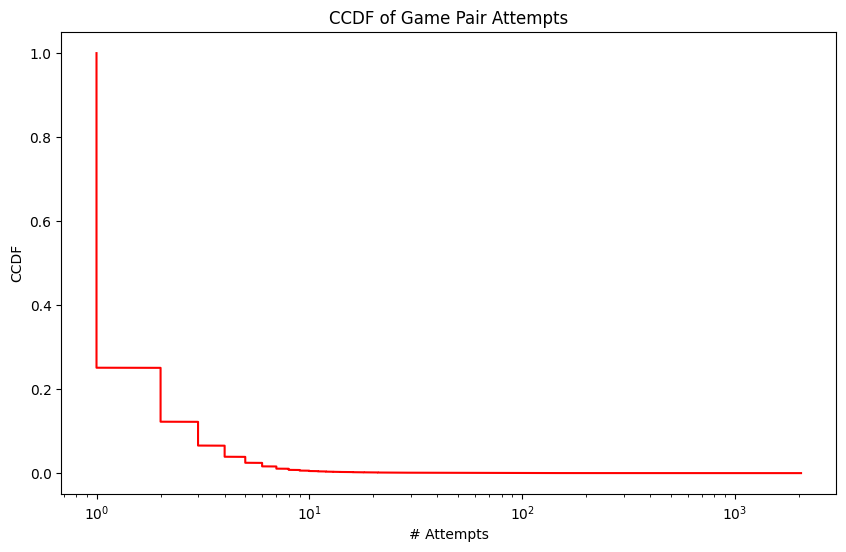

In [494]:
# CCDF of game attempts
y = np.linspace(0, 1, len(game_pair_counts['human_attempts'].sort_values()))
ccdf = 1 - y
plt.figure(figsize=(10,6))
plt.plot(game_pair_counts['human_attempts'].sort_values(), ccdf, color='red')
plt.xlabel('# Attempts')
plt.ylabel('CCDF')
plt.title('CCDF of Game Pair Attempts')
plt.xscale('log')
plt.show()

A stunning majority of pairs have been attempted less than 10 times. Clearly, when selecting 10 pairs for our LLM to play, it would not do to choose a random subset, as we need to choose pairs with multiple human attempts in order to make meaningful comparisons to LLM attempts. 

Let us sample a selection of pairs with at least 25 game attempts:

In [498]:
game_pair_cands = game_pair_counts.query('human_attempts >= 25')
display(game_pair_cands.sample(n=10, random_state=55))
print(str(len(game_pair_cands[game_pair_cands['game_pair'].str.contains('Batman')])) + " of the " + str(len(game_pair_cands)) + " games with 25 or more attempts include 'Batman'.")

,game_pair,human_attempts
3,Pyramid->Bean,1586
4,Batman->Wood,223
22,Flower->Adolf_Hitler,55
32,China->Moon,36
52,Bird_migration->Hubble_Space_Telescope,25
5,Bird->Great_white_shark,168
15,Computer->Fruit,65
6,Batman->The_Holocaust,149
28,Archbishop_of_Canterbury->Vietnam,42
38,Manchester->Water,33


10 of the 54 games with 25 or more attempts include 'Batman'.


We can readily see several concepts appearing in multiple games - another issue with random sampling if our goal is to expose the LLM to conceptual variety. We will retain the set of game pairs with more than 25 attempts as our candidate pool but turn now to a means of enforcing conceptual variety.

### 1.2: Category (categories.tsv)

The category data maps Wikipedia pages to conceptual groupings. To ensure the LLM is exposed to a variety of semantic concepts, we can not only ensure no one page appears more than once in our subset of game pairs, but we can also ensure no one category appears more than 1-2 times in our selected subset of game pairs.

Below, we display the distribution of categories across all Wikipedia pages in the global Wikispeedia dataset (blue) and across those Wikipedia pages appearing inside those game pairs attempted 25 or more times (orange). 

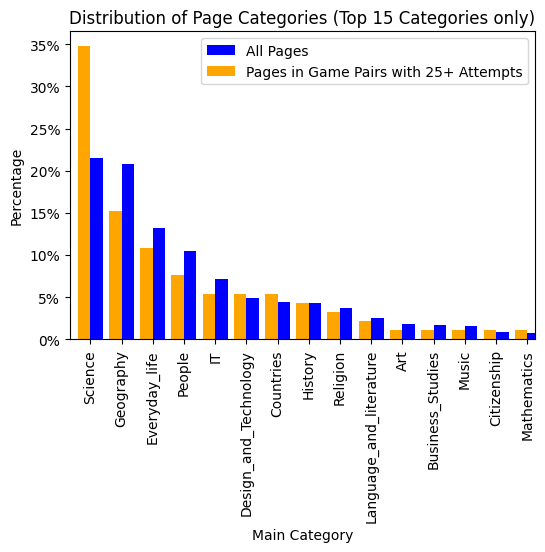

In [500]:
# Pull in categories for all pages appearing inside game pairs
categories_all = pd.read_csv('dependencies/wikispeedia_paths-and-graph/categories.tsv', sep='\t', skiprows=13, header = None, names = ['article','category'])
categories_all[['article', 'category']] = categories_all[['article', 'category']].apply(lambda x: x.map(unquote))
categories_all['main_category'] = categories_all['category'].apply(lambda x: x.split('.')[1] if len(x.split('.')) > 1 else x)
top_categories_all = categories_all['main_category'].value_counts().head(15)

# Isolate categories for those pages appearing inside pairs with at least 20 game attempts
game_pair_cands.loc[:, 'origin'] = game_pair_cands['game_pair'].str.split("->").str[0]
game_pair_cands.loc[:, 'goal'] = game_pair_cands['game_pair'].str.split("->").str[-1]
categories_cands = pd.DataFrame({'article': list(set(pd.concat([game_pair_cands['origin'], game_pair_cands['goal']])))}).merge(right=categories_all, how='left')
top_categories_cands = categories_cands['main_category'].value_counts().head(15)

# display global and subset distribution
percentages_all = (top_categories_all / top_categories_all.sum())
percentages_cands = (top_categories_cands / top_categories_cands.sum())
plt.figure(figsize=(6, 4))
ax = percentages_all.plot(kind='bar', color='blue', position=0, width=0.4)
percentages_cands.plot(kind='bar', color='orange', position=1, width=0.4, ax=ax)

plt.title('Distribution of Page Categories (Top 15 Categories only)')
plt.xlabel('Main Category')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.legend(['All Pages', 'Pages in Game Pairs with 25+ Attempts'])

ax.yaxis.set_major_formatter('{:.0%}'.format)

plt.show()

The distribution of categories for our candidate set is, as with the global set of pages, skewed. However, there still exists enough representation to ensure diversity of category (and therefore concepts pursued by the LLM) among game pairs. 

We attach category information **for goals** to our candidate set and proceed to inspect other variables relevant to our analysis. Candidate game pairs with a goal with more than one primary category are removed to ensure maximum separability of targeted concepts.

In [501]:
game_pair_cands_cats = game_pair_cands.merge(right = categories_cands, left_on='goal', right_on='article')[['game_pair', 'human_attempts', 'origin', 'goal', 'main_category']].copy()
game_pair_cands_cats = game_pair_cands_cats[~game_pair_cands_cats['game_pair'].duplicated(keep=False)].reset_index(drop=True).copy()
game_pair_cands_cats = game_pair_cands_cats.rename(columns={'main_category':'goal_category'})
display(game_pair_cands_cats.head())
print(str(len(game_pair_cands) - len(game_pair_cands_cats)) + " candidate game pairs dropped. " + str(len(game_pair_cands_cats)) + " remain.")

,game_pair,human_attempts,origin,goal,goal_category
0,Brain->Telephone,2044,Brain,Telephone,Design_and_Technology
1,Dog->Telephone,89,Dog,Telephone,Design_and_Technology
2,Jew->Telephone,30,Jew,Telephone,Design_and_Technology
3,Theatre->Zebra,1777,Theatre,Zebra,Science
4,Bird->Great_white_shark,168,Bird,Great_white_shark,Science


13 candidate game pairs dropped. 41 remain.


### 1.3: Average rounds-to-completion, maximum degree along game path, % of attempts containing a backtrack (paths_finished.tsv, paths_unfinished.tsv, links.tsv)

Given the nature of our intended analysis (see Methods section below), it would be helpful to select game pairs for which there is variation in difficulty, connectedness of hubs employed by humans, and propensity of humans to reverse previous decisions. These can be targeted with statistics compiled at the game pair level: average rounds-to-game-completion proxies for difficulty, average maximum outgoing Wikipedia links from a single page on a game path proxies for hub connectedness, and percentage of games in which backtracks occur captures the last variable. 

We first calculate each variable for our candidate game pairs.

In [502]:
def all_to_candidates(all_paths, candidates, new_var_pre_agg, new_var_post_agg, finished_only):
    """For mapping all_path data to candidate set"""
    if finished_only == True:
        all_pairs_avg = all_paths[all_paths['finished'] == 1].groupby('game_pair')[new_var_pre_agg].agg('mean').reset_index().copy()
    else:
        all_pairs_avg = all_paths.groupby('game_pair')[new_var_pre_agg].agg('mean').reset_index().copy()
    all_pairs_avg = all_pairs_avg.rename(columns={new_var_pre_agg:new_var_post_agg})
    return candidates.merge(right=all_pairs_avg, on='game_pair').copy()

In [503]:
## Average rounds-to-completion
all_paths['game_length'] = all_paths['path_decoded'].apply(len)
all_paths.loc[all_paths['finished'] == 0, 'game_length'] = np.nan
game_pair_cands_cats_oth = all_to_candidates(all_paths, game_pair_cands_cats, 'game_length', 'avg_game_length', True)

In [504]:
## Average max degree along game path
outgoing_links = {}
degrees = {}

# Create dictionaries for links connections and degrees
df = pd.read_csv('dependencies/wikispeedia_paths-and-graph/links.tsv', sep='\t', skiprows=12, header=None)
for index, row in df.iterrows(): 
    start_page = urllib.parse.unquote(row[0])
    link_page = urllib.parse.unquote(row[1])
    if start_page in outgoing_links:
        outgoing_links[start_page].append(link_page)
    else:
        outgoing_links[start_page] = [link_page]
for key in outgoing_links.keys():
    degrees[key] = len(outgoing_links[key])

def get_degree_from_wikipedia_page(page_title):
    return degrees.get(page_title,np.nan)
def calculate_degrees(game_path):
    return [get_degree_from_wikipedia_page(page) for page in game_path]

# Map game path to degree path
all_paths['degrees'] = [calculate_degrees(game_path) for game_path in all_paths['path_decoded']]

# Calculate max degree in a given game (function handles missing values)
def find_max(lst):
    return max(lst) if lst else None  # Return None for empty lists
all_paths['max_degree'] = all_paths['degrees'].apply(max)

# Now average and combine with candidate set
game_pair_cands_cats_oth = all_to_candidates(all_paths, game_pair_cands_cats_oth, 'max_degree', 'avg_max_degree', True)

In [505]:
## % of games with backtrack
all_paths['backtrack_occurred'] = all_paths['path_decoded'].apply(lambda x: any('<' in page for page in x))
game_pair_cands_cats_oth = all_to_candidates(all_paths, game_pair_cands_cats_oth, 'backtrack_occurred', 'share_backtrack_occurred', finished_only = False)

In [506]:
# updated candidate df
game_pair_cands_cats_oth.head()

,game_pair,human_attempts,origin,goal,goal_category,avg_game_length,avg_max_degree,share_backtrack_occurred
0,Brain->Telephone,2044,Brain,Telephone,Design_and_Technology,7.100000,95.138462,0.177104
1,Dog->Telephone,89,Dog,Telephone,Design_and_Technology,7.622642,163.622642,0.224719
2,Jew->Telephone,30,Jew,Telephone,Design_and_Technology,6.444444,244.277778,0.133333
3,Theatre->Zebra,1777,Theatre,Zebra,Science,7.836464,166.501657,0.195273
4,Bird->Great_white_shark,168,Bird,Great_white_shark,Science,5.695652,57.391304,0.059524


We are now equipped with all we need to select our 10 game pairs. We select our game pairs in the next section and visualize their location over distributions for our selection variables.

Note that we did not include share of games abandoned in our set of relevant variables because we already had a proxy for difficulty and a metric quantifying backtracks; further selection variables would only complicate extraction of our subset.

### 1.4: Selecting the 10 game pairs the LLM will play

Our subset of 10 game pairs will fulfill the following requirements:
- No one article appears as an origin or goal more than once
- No goal article category appears more than twice
- The sum of the standard errors of standardized avg_game_length, avg_max_degree, and share_backtrack_occurred in the subset is the maximum across all subsets matching the above conditions

We achieve these conditions with the loop below.

In [444]:
# Standardize quantitative variables 
quant_vars = ['avg_game_length', 'avg_max_degree', 'share_backtrack_occurred']
quant_vars_new = ['avg_game_length_stdiz', 'avg_max_degree_stdiz', 'share_backtrack_occurred_stdiz']
game_pair_cands_cats_oth[quant_vars_new] = (game_pair_cands_cats_oth[quant_vars] - game_pair_cands_cats_oth[quant_vars].mean()) / game_pair_cands_cats_oth[quant_vars].std()

# Select subset!
def find_10_pairs_for_llm():
    seed = 5
    sample = "none"
    running_se_sum = 0
    failed_to_update = 0
    while failed_to_update < 500:
        seed += 1
        tmp_sample = game_pair_cands_cats_oth.sample(n=10, random_state=seed)
        # confirm pages only appear once as origin or goal
        if len(set(pd.concat([tmp_sample['origin'], tmp_sample['goal']]))) != 20:
            pass
        # confirm categories only appear once or twice among goal
        elif tmp_sample['goal_category'].value_counts().max() > 2:
            pass
        # allow final set to update if quantitative var standard error sum is higher
        else:
            sample_se_sum = tmp_sample['avg_game_length_stdiz'].var() + tmp_sample['avg_max_degree_stdiz'].var() + tmp_sample['share_backtrack_occurred_stdiz'].var()
            if sample_se_sum > running_se_sum:
                print('new sample')
                sample = tmp_sample
                running_se_sum = sample_se_sum
                failed_to_update = 0
            else:
                failed_to_update += 1
    return sample
final_pairs = find_10_pairs_for_llm()

final_pairs.to_csv("dependencies/game_pairs_for_LLM.csv")
display(final_pairs['game_pair'])



new sample
new sample
new sample
new sample
new sample
new sample
new sample


25     14th_century->Rainbow
7         Bird->Adolf_Hitler
30      Batman->Coconut_crab
29           Africa->England
27    George_W._Bush->Monkey
37    Antlion->Hip_hop_music
14          Aircraft->Google
22                Jesus->God
16           Computer->Fruit
2             Jew->Telephone
Name: game_pair, dtype: object

We can confirm our unique concept and mostly unique category conditions with visual inspection:

In [507]:
display(final_pairs)

,game_pair,human_attempts,origin,goal,goal_category,avg_game_length,avg_max_degree,share_backtrack_occurred,avg_game_length_stdiz,avg_max_degree_stdiz,share_backtrack_occurred_stdiz
25,14th_century->Rainbow,50,14th_century,Rainbow,Geography,7.444444,80.592593,0.200000,0.439756,-1.182207,0.494393
7,Bird->Adolf_Hitler,129,Bird,Adolf_Hitler,People,5.401869,153.214953,0.100775,-0.621009,0.296003,-0.595969
30,Batman->Coconut_crab,35,Batman,Coconut_crab,Science,10.181818,76.181818,0.428571,1.861348,-1.271987,3.006120
29,Africa->England,35,Africa,England,Geography,4.333333,212.000000,0.000000,-1.175928,1.492558,-1.703368
27,George_W._Bush->Monkey,37,George_W._Bush,Monkey,Science,10.588235,135.235294,0.405405,2.072411,-0.069968,2.751553
37,Antlion->Hip_hop_music,29,Antlion,Hip_hop_music,Music,6.250000,213.250000,0.206897,-0.180551,1.518001,0.570178
14,Aircraft->Google,78,Aircraft,Google,IT,9.342857,191.742857,0.243590,1.425653,1.080229,0.973392
22,Jesus->God,27,Jesus,God,Religion,2.000000,59.000000,0.000000,-2.387691,-1.621719,-1.703368
16,Computer->Fruit,65,Computer,Fruit,Everyday_life,8.344828,114.034483,0.200000,0.907349,-0.501506,0.494393
2,Jew->Telephone,30,Jew,Telephone,Design_and_Technology,6.444444,244.277778,0.133333,-0.079571,2.149564,-0.238194


Furthermore, we can confirm our pairs exhibit sufficient variance with respect to our quantitative selection variables by displaying them on a global distribution:

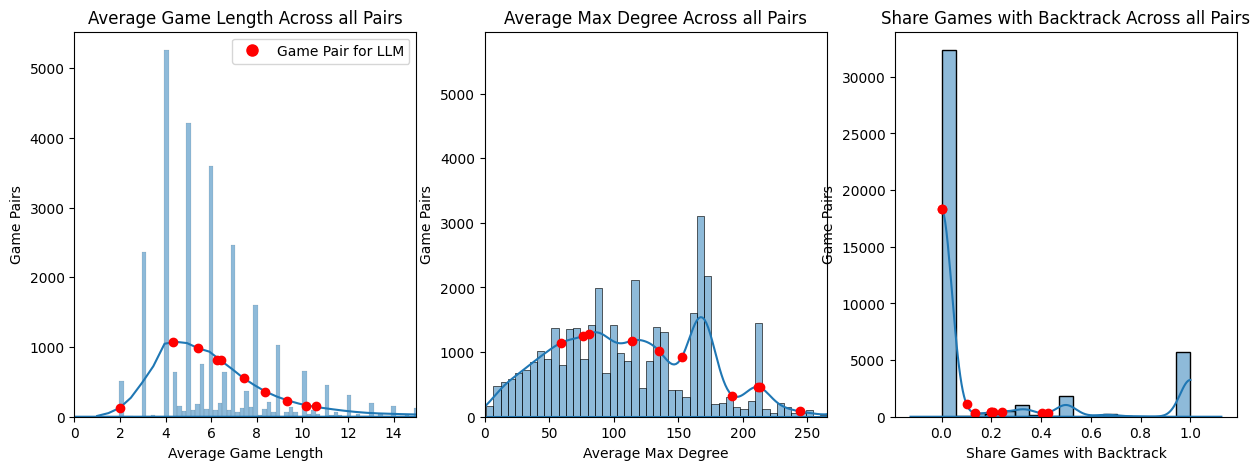

In [509]:
all_pairs_qvars =all_paths.groupby('game_pair')[['max_degree', 'backtrack_occurred', 'game_length']].agg('mean').reset_index()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
def histogram_w_final_selection(qvar, agg_adder, x_label, ax):
    sns.histplot(data=all_pairs_qvars, x=qvar, kde=True, ax=ax)
    kde = sns.kdeplot(data=all_pairs_qvars[qvar], legend=False, ax=ax)
    kde_data = kde.get_lines()[0].get_data()

    final_pairs_location = final_pairs[agg_adder + qvar]
    for x in final_pairs_location:
        closest_index = np.argmin(np.abs(kde_data[0] - x))
        y = kde_data[1][closest_index]
        ax.plot(x, y, 'ro')

    ax.set_xlabel(x_label)
    ax.set_ylabel('Game Pairs')
    ax.set_title(x_label + ' Across all Pairs')
    if qvar == 'game_length':
        ax.set_xlim(0,15)
        legend_elements = [Line2D([0], [0], marker='o', color='red', label='Game Pair for LLM', markersize=8, linestyle='None')]
        ax.legend(handles=legend_elements)
    if qvar == 'max_degree':
        ax.set_xlim(0,265)
    
histogram_w_final_selection('game_length', 'avg_', 'Average Game Length', axs[0])
histogram_w_final_selection('max_degree', 'avg_', 'Average Max Degree', axs[1])
histogram_w_final_selection('backtrack_occurred', 'share_', 'Share Games with Backtrack', axs[2])

With a set of 10 game pairs played 25 times or more that vary in target category while also exhibiting a varied and representative distribution of average game length, average maximum degree on game path, and share of games with backtracking, we know now the Wikispeedia games we can ask an LLM to play that will yield data relevant to our research questions.

However, we cannot begin developing external data without settling on an LLM and prompt architecture. This is subject of the next section. 

# LLM and Prompt Selection

In [ ]:
# show results for different LLMs
# show results for different prompts
# explain selection of LLM and prompt

# Methods

We use this section to demonstrate some of the analysis we will perform once we have LLM-derived Wikispeedia data. 

At present, human-derived Wikispeedia data is used as a 'stand-in' for LLM-derived data where necessary. 

In [4]:
# tmp - should be handled above.


llm_wikispeedia_pairs = pd.read_csv('dependencies/llm_wikispeedia_pairs.csv')
paths_finished = pd.read_csv('dependencies/wikispeedia_paths-and-graph/paths_finished.tsv', sep='\t', skiprows = 16, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
paths_unfinished = pd.read_csv('dependencies/wikispeedia_paths-and-graph/paths_unfinished.tsv', sep='\t', skiprows=17, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
pfin_etc = pd.concat([paths_finished['path'].str.split(";").apply(lambda path: path[0]), paths_finished['path'].str.split(";").apply(lambda path: path[-1]), paths_finished['path'].str.split(";").apply(lambda path: len(path)), paths_finished['path'].str.split(";").apply(lambda path: path)], axis=1)
pfin_etc.columns = ['origin', 'goal', 'path_l', 'path']
most_popular = pfin_etc.groupby(by=['origin', 'goal']).agg('count').rename(columns={"path_l": "total_pair_rounds"}).sort_values(by='total_pair_rounds', ascending=False).reset_index()[0:10][['origin', 'goal', 'total_pair_rounds']]
most_popular.to_csv('dependencies/top10pairs.csv')

### Are LLM paths sensical to humans?

In [5]:
# pull in BART encodings
# encode concepts in LLM paths
# across all LLM games of length N, find the embedding distance to goal and embedding distances to next page at each round
# plot these curves
# calculate proportion that strictly decrease throughout game
# supplement with Word2Vec embeddings, TF-IDF Wikipage embeddings

In [9]:
# BART

In [ ]:


# Load pre-trained model and tokenizer
model = 'facebook/bart-large'
tokenizer = BartTokenizer.from_pretrained(model)
bartm = BartModel.from_pretrained(model)

# List of words to embed
word_list = ['apple', 'orange', 'banana', 'grape', 'pineapple']

# Encode words and retrieve embeddings
word_embeddings = {}
for word in word_list:
    input_ids = tokenizer.encode(word, return_tensors='pt')
    with torch.no_grad():
        output = model(input_ids=input_ids)
    last_hidden_states = output.last_hidden_state.squeeze().mean(dim=0).numpy()
    word_embeddings[word] = last_hidden_states

# Calculate distances between embeddings
distance = cosine(word_embeddings[word1], word_embeddings[word2])


In [ ]:
# TF-IDF vectorizer

In [ ]:

# Sample corpus (replace this with your text data)
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the corpus to TF-IDF vectors
tfidf_matrix = vectorizer.fit_transform(corpus)

# Get the feature names (words) in the corpus
feature_names = vectorizer.get_feature_names_out()

# Print the TF-IDF matrix and feature names
print("TF-IDF Matrix:")
print(tfidf_matrix.toarray())
print("\nFeature Names:")
print(feature_names)


### Are LLM paths faster or slower than humans'?

In [ ]:
# across all LLM games of pair origin-goal, find the avg rounds needed to complete game
# do the same for human games of pair origin-goal
# match origin-goal pairs across LLM and humans
# perform a t-test on the difference in match averages 

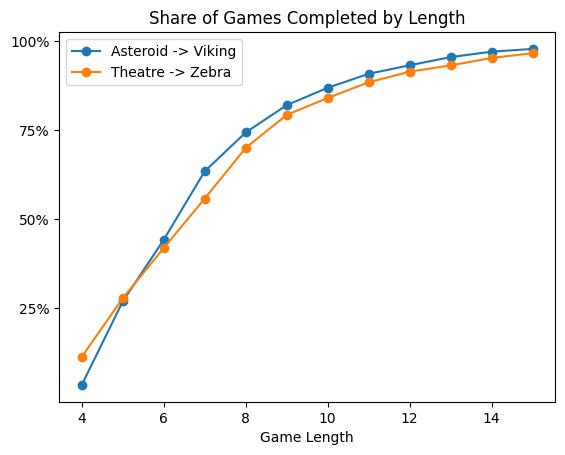

In [173]:
# distribution of game lengths for a couple popular origin-goal pairs
lengths = pd.merge(most_popular, pfin_etc, how='left', on=['origin', 'goal'])
lengths = lengths.groupby(['origin', 'goal', 'path_l']).agg('count') / lengths.groupby(['origin', 'goal']).agg('count')
lengths = lengths['total_pair_rounds'].reset_index().query("(origin == 'Asteroid' and goal == 'Viking') or (origin == 'Theatre' and goal == 'Zebra')")
lengths['cum_completed'] = lengths.groupby(['origin', 'goal'])['total_pair_rounds'].agg('cumsum')
lengths = lengths.query('path_l <= 15')

# graph
groups = lengths.groupby(['origin', 'goal'])
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group['path_l'], group['cum_completed'], marker='o', label=(name[0] + " -> " + name[1]))

ax.set_xlabel('Game Length')
ax.set_ylabel('')
ax.set_title('Share of Games Completed by Length')
#ax.set_yscale('log')
ax.set_yticks([.25, .5, .75, 1])
ax.set_yticklabels(['25%', '50%', '75%', '100%'])
ax.legend()
plt.show()

Though the graph above displays cumulative completions rates by game length for two *human*-derived page pairs, once we have LLM-derived data, we can match page pairs between our LLM and humans to observe differences in game length distributions - both at the pair level and in the aggregate.

### Do LLMs employ the same 'zoom-out' to hub, 'zoom-in' to spoke strategy as humans?

In [ ]:
# across all LLM games of length N, calculate average degree (length of prompt list) at each round
# fit curve to quadratic model, perform goodness of fit tests
# stronger version: test for equality of curves between humans and LLM for the same page pair

In [5]:


links = {}
df = pd.read_csv('dependencies/wikispeedia_paths-and-graph/links.tsv', sep='\t', skiprows=12, header=None)
for index, row in df.iterrows(): 
    start_page = urllib.parse.unquote(row[0])
    link_page = urllib.parse.unquote(row[1])
    if start_page in links:
        links[start_page].append(link_page)
    else:
        links[start_page] = [link_page]
def get_links_from_wikipedia_page(page_title):
    return links.get(page_title, [])

paths = pd.merge(most_popular, pfin_etc, how='left', on=['origin', 'goal'])
paths['degree_path'] = paths['path'].apply(lambda path: [len(get_links_from_wikipedia_page(page)) for page in path])

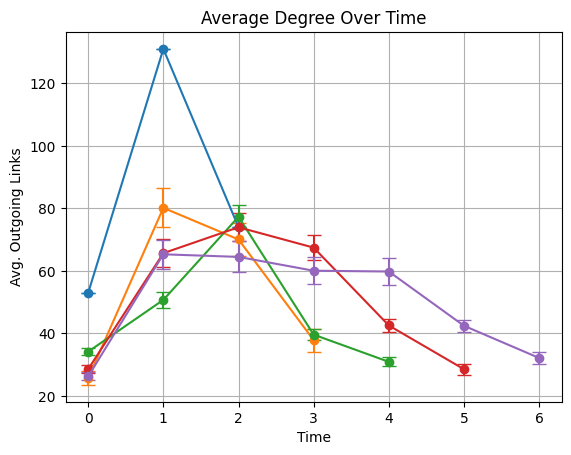

In [10]:
mea_at_stage = {}
moe_at_stage = {}

for game_length in [3, 4, 5, 6, 7]:
    mea_at_stage[game_length] = {}
    moe_at_stage[game_length] = {}
    for i, row in paths.iterrows():
        if len(row['degree_path']) == game_length:
            for j in range(len(row['degree_path'])):
                if j not in mea_at_stage[game_length].keys():
                    mea_at_stage[game_length][j] = []
                mea_at_stage[game_length][j].append(row['degree_path'][j])
    for key in mea_at_stage[game_length].keys():
        moe_at_stage[game_length][key] = 1.96 * (np.std(mea_at_stage[game_length][key], ddof=1) / np.sqrt(len(mea_at_stage[game_length][key])))
        mea_at_stage[game_length][key] = (np.mean(mea_at_stage[game_length][key]))
    
for game_length in [3, 4, 5, 6, 7]:
    mean_list = list(mea_at_stage[game_length].values())
    mofe_list = list(moe_at_stage[game_length].values())
    plt.errorbar(range(len(mean_list)), mean_list, yerr=mofe_list, fmt='-o', capsize=5)
 
plt.xlabel('Time')
plt.ylabel('Avg. Outgoing Links')
plt.title('Average Degree Over Time')
plt.grid(True)
plt.show()

The graph above displays average page degree at each stage of 3-, 4-, 5-, 6-, and 7-round games. Each curve has just one local (and therefore global) maximum that occurs *after* the initial page. This corresponds to a 'zoom-out', 'zoom-in' strategy. Once we have LLM-derived data, we can calculate the same degree averages for LLM paths and use the function below to check if the resultant curves have just one global maximum.

In [23]:
def count_local_maxima(means):
    loc_max = 0
    for i in range(1, len(means) - 1):
        if means[i] > means[i - 1] and means[i] > means[i + 1]:
            loc_max += 1
    if loc_max == 1:
        pass
    else:
        print("Multiple local maxima!")

for game_degree in [3, 4, 5, 6, 7]:
    count_local_maxima(list(mea_at_stage[game_degree].values()))

### Does LLM 'backtrack' behavior differ from humans?

In [187]:
# If LLM cycles, remove intermediary pages and treat cycle as a 'backtrack'
# tbd


[19, 58, 60, 22, 23, 23, 43, 62]